# Combining partially mactched Targets #1 and #3

The purpose of this notebook is to look at generate simple models for Cas13d binding 

In [3]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3, venn3_circles
from scipy.stats import pearsonr
import yaml
import RNA
import h5py
from uncertainties import ufloat
from uncertainties.umath import log
from scipy import stats

## Load the data and sequence

In [4]:
#define target seqeunce #1, #3, prefix and suffix
#prefix and suffix are constant region of the entrire transcribed RNA, only PFS region is different from different target
target1 = 'CCATAGAGAGGTTATCCGCTCA'
target3 = 'TTTGATCTGAAATATTCAGGTC'
target1_prefix = 'GGGAATGGATCCACATCTACGAATTCGTA'
target1_suffix = 'CCGAGATCGGAAGAGCACACGT'
target3_prefix = 'GGGAATGGATCCACATCTACGAATTCGTT'
target3_suffix = 'TGCAGATCGGAAGAGCACACGT'

In [5]:
#load datasets
#columns are entire transcribed sequences, predicted RNA structure, MFE, and normzalized ABA
target1_f_path = 'target1.csv'
target3_f_path = 'target3.csv'
df1 = pd.read_csv(target1_f_path)
df3 = pd.read_csv(target3_f_path)

In [6]:
df1.head()

,sequence,structure,mfe,ABA_normalized
0,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTAGG...,.........(((..((((.((...(((((((.......)))....)...,-10.600000,0.628832
1,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGGTTATCCG...,((((.(((((...(.((((((....))).....))).)...)))))...,-14.100000,0.109211
2,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTATC...,((((.((((((....((((((....))).....)))..))))))))...,-19.299999,0.462700
3,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGGTTATCCG...,.((.((((((.(........).)))))).))......((....))(...,-11.300000,0.277148
4,GGGAATGGATCCACATCTACGAATTCGTACGCATAGAGAGGTTATC...,......((((((...((((((........))..))))..))..)))...,-14.400000,0.349502


<AxesSubplot:>

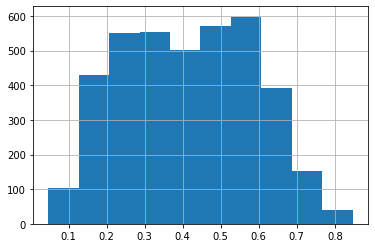

In [5]:
df1['ABA_normalized'].hist()

In [24]:
df3.head()

,sequence,structure,mfe,ABA_normalized
0,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATAG...,.(((.....)))......(((....(.(((((((((((.....(((...,-13.3,0.113309
1,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATAT...,.(((.....)))......(((....(.(((((((((((...........,-12.9,0.217590
2,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATTC...,.(((.....)))......(((....(.(((((((((((.......(...,-13.2,0.336245
3,GGGAATGGATCCACATCTACGAATTCGTTTGTGATCTGAAATATTC...,..(((((((((.(((...(((....))).)))))))).....))))...,-14.7,0.122793
4,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATCT...,.(((.....)))......(((....(.(((((((((((...........,-13.1,0.137947


<AxesSubplot:>

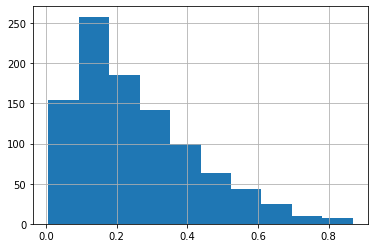

In [13]:
df3['ABA_normalized'].hist()

In [7]:
#This function recovers the sequence of changes (insertions/deletions/replacements(mismatch))
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output


# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement (mismatch), d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return (coord[0]-1)*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return (coord[0]-1)*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return (coord[0]-1)*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return (coord[0]-1)*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return (coord[0]-1)*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return (coord[0]-1)*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return (coord[0]-1)*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return (coord[0]-1)*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return (coord[0]-1)*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1


#RNA structure prediction, the output would be the structure in the target sequence and mfe
def structure_cr1(sequence):
    ss,mfe = RNA.fold((target1_prefix[:]+sequence+target1_suffix[:]).replace('T', 'U'))
    RNA_seq = (target1_prefix[:]+sequence+target1_suffix[:]).replace('T', 'U')
    return RNA_seq[29:-22],ss[29:-22],mfe
def structure_cr3(sequence):
    ss,mfe = RNA.fold((target3_prefix[:]+sequence+target3_suffix[:]).replace('T', 'U'))
    RNA_seq = (target3_prefix[:]+sequence+target3_suffix[:]).replace('T', 'U')
    return RNA_seq[29:-22],ss[29:-22],mfe


#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual", ylabel="Fit (ABA)", xlabel="Measured (ABA)"):
    x,y = actual,predicted 
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, edgecolors='none', gridsize=75,cmap='viridis',mincnt=1)
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)), "k--")

    ax_scatter.set_xlabel(xlabel, fontsize=15)
    ax_scatter.set_ylabel(ylabel, fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    ax_scatter.set_xlim((-0.1, 0.9))
    ax_scatter.set_ylim((-0.1, 0.9))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 50
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())


    #plt.show()
    
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.ylabel("predicted ABA")
    plt.xlabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions

def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
    


## Relative encoding model only

In [8]:
#Relative encoding encodes the changes (deletions, insertions, or replacements[mismatches]) to the matched target for input sequences

def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 1:
            coords = get_diff(perfect_sequence, seq[29:-22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    return X, y

In [9]:
df1_encoding, aba1 = create_matrix(df1, perfect_sequence = target1)
df3_encoding, aba3 = create_matrix(df3, perfect_sequence = target3)

#combining target1 & target 3
combined_encoding = np.concatenate((df1_encoding, df3_encoding), axis=0)

combined_aba = np.concatenate((aba1, aba3), axis=0)
combined_aba.shape

/var/folders/p5/l5gcbv092dnbg4zypnpchks00000gn/T/ipykernel_62911/366681199.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
/var/folders/p5/l5gcbv092dnbg4zypnpchks00000gn/T/ipykernel_62911/366681199.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()


(4806,)

test correlation is 0.674256172412814
-5702.34350716325


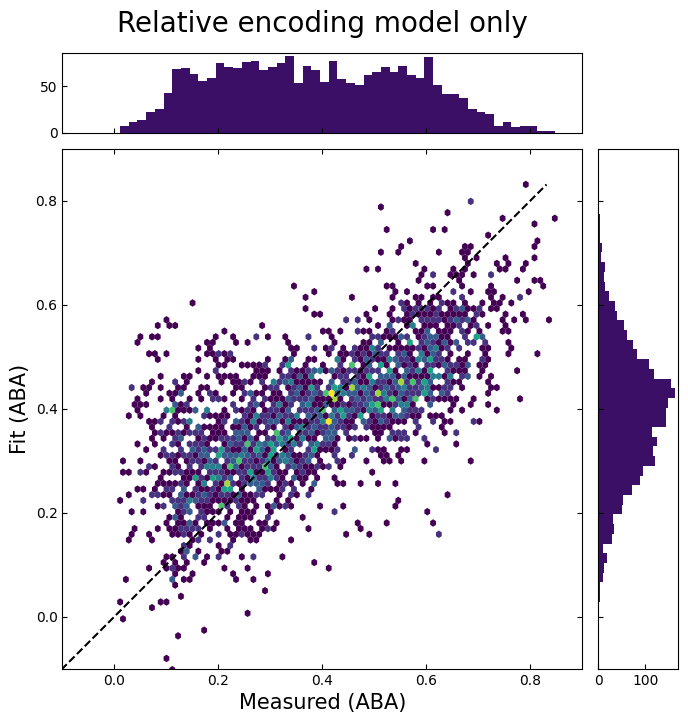

In [12]:
#The model is trained on half of the dataset and tested on the rest

X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = int(len(combined_aba)/2)

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Relative encoding model only")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model1 = regr.aic
print(regr.aic)

## Relative encoding + Free Energy(MFE) model

In [13]:
def create_matrix2(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 1:
            coords = get_diff(perfect_sequence, seq[29:-22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #  add MFE to the relative encoding model   
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['mfe'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

In [14]:
df1_encoding, aba1 = create_matrix2(df1, perfect_sequence = target1)
df3_encoding, aba3 = create_matrix2(df3, perfect_sequence = target3)

combined_encoding = np.concatenate((df1_encoding, df3_encoding), axis=0)

combined_aba = np.concatenate((aba1, aba3), axis=0)
combined_aba.shape

(4806,)

test correlation is 0.6589731606736187
-5732.942200167634


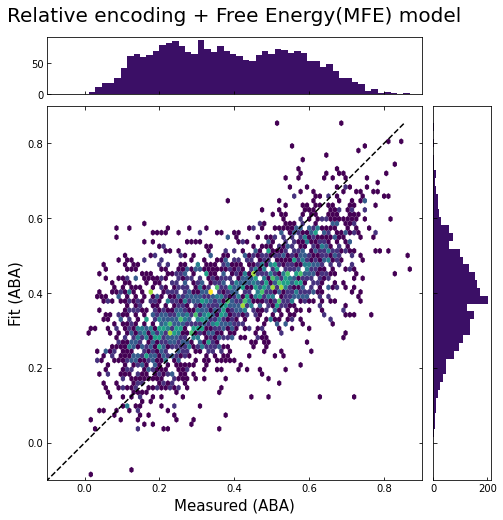

In [15]:
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = int(len(combined_aba)/2)

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]


reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Relative encoding + Free Energy(MFE) model")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENERGY_ENC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model2 = regr.aic
print(regr.aic)

## Free energy (MFE) only model

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


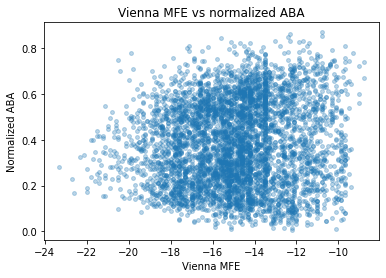

In [16]:
#  Plot the correlation of MFE normalized ABA 
plt.xlabel("Vienna MFE")
plt.ylabel("Normalized ABA")
plt.title("Vienna MFE vs normalized ABA")
plt.scatter(list(df1['mfe'])+list(df3['mfe']),
            list(df1['ABA_normalized'])+list(df3['ABA_normalized']),
            alpha=0.3, s=15, c=[0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.3])
plt.show()

In [17]:
ENERGY_CORR= pearsonr(list(df1['mfe'])+list(df3['mfe']),
            list(df1['ABA_normalized'])+list(df3['ABA_normalized']))[0]
print (ENERGY_CORR)

0.09098886547783665


# Basepairing only model

In [18]:
#this function transform the  ".((..)).." structural information in to binary information
def dots_to_features(string):
    arr = []
    for char in string:
        if char == '.':
            arr.append(0)
        elif char == ')' or char == '(':
            arr.append(1)
    return arr

# Generate a matrix in the target sequences which "(" = 1, "." = 0.
def generate_structure_matrix(table):
    X, y = [],[]
    for i, row in table.iterrows():
        ss = row['structure']
        X.append(dots_to_features(ss)[29:29+22])
        y.append(row['ABA_normalized'])
    return np.array(X), np.array(y)

test correlation is 0.48872906323785176
-4231.707896567823


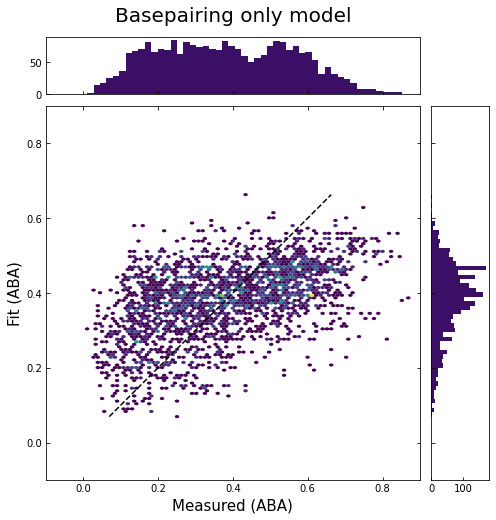

In [20]:
X,y = generate_structure_matrix(pd.concat([df1,df3], axis=0))

X, y = shuffle(X,y)
cutoff = int(len(X)/2)

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Basepairing only model")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model3 = regr.aic
print(regr.aic)

## Basepairing + MFE model

In [32]:
#add additional MFE to basepairing model

def generate_bp_mfe_matrix(table):
    X, y = [],[]
    for i, row in table.iterrows():
        output = []
        ss = row['structure']
        output.append(row['mfe'])
        output.extend(dots_to_features(ss)[29:29+22])
        X.append(output)
        y.append(row['ABA_normalized'])
    return np.array(X), np.array(y)

test correlation is 0.5416154817490687
-4406.251436531464


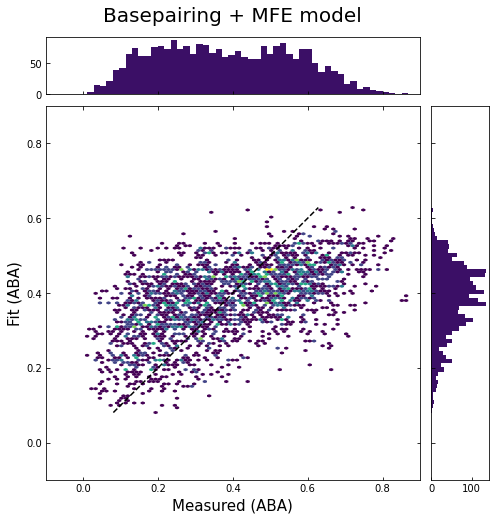

In [39]:
X,y = generate_bp_mfe_matrix(pd.concat([df1,df3], axis=0))

X, y = shuffle(X,y)
cutoff = int(len(X)/2)

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Basepairing + MFE model")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_ENERGY_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model4 = regr.aic
print(regr.aic)

## Combining basepairing and relative encoding model

In [36]:
def create_matrix_with_bp(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 1:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                bindings = big_table[big_table['sequence'] == seq].iloc[0]['structure']
                row.extend((dots_to_features(bindings))[29:29+22])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                
    X = np.array(pruned_combined_data_matrix)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    return X, y

In [37]:
df1_encoding, aba1 = create_matrix_with_bp(df1, perfect_sequence = target1)
df3_encoding, aba3 = create_matrix_with_bp(df3, perfect_sequence = target3)

#combining target1 & target 3
combined_encoding = np.concatenate((df1_encoding, df3_encoding), axis=0)

combined_aba = np.concatenate((aba1, aba3), axis=0)
combined_aba.shape

(4806,)

test correlation is 0.7504335045558433
-6972.645007446832


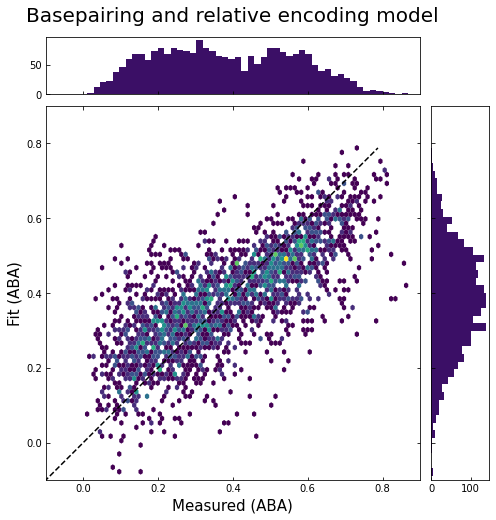

In [40]:
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = int(len(X)/2)

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Basepairing and relative encoding model")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model5 = regr.aic
print(regr.aic)

## Combining structure and relative encoding

In [56]:
def create_matrix_with_structure(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 1:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['mfe'])
                bindings = big_table[big_table['sequence'] == seq].iloc[0]['structure']
                row.extend((dots_to_features(bindings))[29:29+22])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                
    X = np.array(pruned_combined_data_matrix)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    return X, y

In [57]:
df1_encoding, aba1 = create_matrix_with_structure(df1, perfect_sequence = target1)
df3_encoding, aba3 = create_matrix_with_structure(df3, perfect_sequence = target3)

#combining target1 & target 3
combined_encoding = np.concatenate((df1_encoding, df3_encoding), axis=0)

combined_aba = np.concatenate((aba1, aba3), axis=0)
combined_aba.shape

(4806,)

test correlation is 0.7602354273457653
-7056.5021270490815


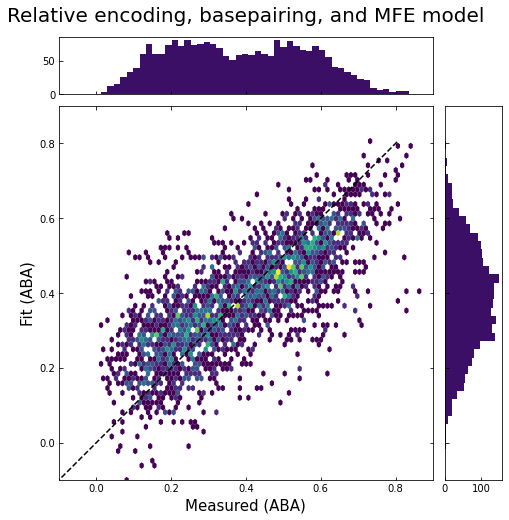

In [53]:
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = int(len(X)/2)

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Relative encoding, basepairing, and MFE model")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_ENERGY_CORR = corr
regr = OLS(y, add_constant(X)).fit()
model6 = regr.aic
print(regr.aic)